## Import library

In [1]:
import os
import cv2
import torch
import torch.nn as nn
import numpy as np
from skimage.feature import graycomatrix, graycoprops
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import torch.nn as nn

## Import Env File

In [3]:
from dotenv import load_dotenv  

load_dotenv()
datasets_path = os.getenv('DATASET_PATH')
models_path = os.getenv('MODELS_PATH')

## Device Configuration

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Parameters

In [5]:
num_classes = 2
batch_size = 16
test_split_ratio = 0.2
image_size = (224, 224)

## Data Preprocessing

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Custom Dataset With GLCM Features

In [7]:
class GLCMCNNHybridDataset(Dataset):
    def __init__(self, image_folder_dataset, transform=None):
        self.image_folder_dataset = image_folder_dataset
        self.transform = transform

    def extract_glcm_features(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        glcm = graycomatrix(gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
        features = [
            graycoprops(glcm, 'contrast')[0, 0],
            graycoprops(glcm, 'dissimilarity')[0, 0],
            graycoprops(glcm, 'homogeneity')[0, 0],
            graycoprops(glcm, 'energy')[0, 0],
            graycoprops(glcm, 'correlation')[0, 0],
        ]
        return features

    def __getitem__(self, index):
        image, label = self.image_folder_dataset[index]

        if self.transform:
            image = self.transform(image)

        # Convert tensor to numpy image (H, W, C) for GLCM extraction
        image_np = image.permute(1, 2, 0).cpu().numpy()
        image_np = (image_np * 255).astype(np.uint8)

        glcm_features = self.extract_glcm_features(image_np)
        glcm_features = torch.tensor(glcm_features, dtype=torch.float32)

        return image, glcm_features, label

    def __len__(self):
        return len(self.image_folder_dataset)

## Data Loaders

In [8]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

# Buat dataset dengan ImageFolder
base_dataset = datasets.ImageFolder(root=datasets_path)

# Bungkus dengan GLCMCNNHybridDataset
hybrid_dataset = GLCMCNNHybridDataset(base_dataset, transform=transform)

# Ambil semua label dari base_dataset untuk stratified split
targets = base_dataset.targets  # Ini adalah daftar label (misal: [0, 1, 0, 1, ...])

# Buat daftar semua indeks
indices = list(range(len(base_dataset)))

# Stratified split berdasarkan label
train_indices, test_indices = train_test_split(
    indices,
    test_size=test_split_ratio,
    stratify=targets,
    random_state=42
)

# Buat subset stratified dari hybrid_dataset
train_dataset = Subset(hybrid_dataset, train_indices)
test_dataset = Subset(hybrid_dataset, test_indices)

# DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [9]:
from collections import Counter

print("Distribusi kelas (train):", Counter([base_dataset.targets[i] for i in train_indices]))
print("Distribusi kelas (test):", Counter([base_dataset.targets[i] for i in test_indices]))

Distribusi kelas (train): Counter({0: 80, 1: 77})
Distribusi kelas (test): Counter({0: 20, 1: 20})


## Load Pre-Trained Model (EfficientNet)

In [10]:
# Load EfficientNet-B0
weights = EfficientNet_B0_Weights.DEFAULT
cnn_model = efficientnet_b0(weights=weights)
cnn_feature_size = cnn_model.classifier[1].in_features  # EfficientNet features

# Replace classification layer to get features
cnn_model.classifier = nn.Identity()
cnn_model = cnn_model.to(device)

## Hybrid Model

In [11]:
class PararelModel(nn.Module):
    def __init__(self, cnn_model, glcm_feature_size, cnn_feature_size, num_classes):
        super(PararelModel, self).__init__()
        self.cnn_model = cnn_model
        self.fc1 = nn.Linear(glcm_feature_size + cnn_feature_size, 512)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, image, glcm_features):
        cnn_features = self.cnn_model(image)
        combined_features = torch.cat((glcm_features, cnn_features), dim=1)
        x = self.fc1(combined_features)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

## Simplified Hybrid Model

In [29]:
class SimpleParallelModel(nn.Module):
    def __init__(self, cnn_model, glcm_feature_size, cnn_feature_size, num_classes):
        super(SimpleParallelModel, self).__init__()
        self.cnn_model = cnn_model
        self.fc1 = nn.Linear(glcm_feature_size + cnn_feature_size, 256)  # Menurunkan dimensi
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, num_classes)  # Langsung ke output class

    def forward(self, image, glcm_features):
        cnn_features = self.cnn_model(image)
        combined_features = torch.cat((glcm_features, cnn_features), dim=1)
        x = self.fc1(combined_features)
        x = self.relu(x)
        x = self.fc2(x)
        return x

## Initialize Hybrid Model

In [30]:
glcm_feature_size = 5  # Number of GLCM features
# model = PararelModel(cnn_model, glcm_feature_size, cnn_feature_size, num_classes).to(device)
model = SimpleParallelModel(cnn_model, glcm_feature_size, cnn_feature_size, num_classes).to(device)

## Train The Model

In [ ]:
num_epochs = 50
patience = 5  # jumlah epoch tanpa perbaikan sebelum berhenti
best_loss = float('inf')
epochs_no_improve = 0

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
learning_rate = 0.000001
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop dengan early stopping
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, glcm_features, labels in train_loader:
        images, glcm_features, labels = images.to(device), glcm_features.to(device), labels.to(device)

        # Forward pass
        outputs = model(images, glcm_features)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    # Early Stopping Check
    if epoch_loss < best_loss - 1e-4:
        best_loss = epoch_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Simpan model terbaik
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"⛔ Early stopping triggered at epoch {epoch+1}")
        break


Epoch [1/50], Loss: 4.4920
Epoch [2/50], Loss: 3.9132
Epoch [3/50], Loss: 2.5579
Epoch [4/50], Loss: 1.1072
Epoch [5/50], Loss: 1.3745
Epoch [6/50], Loss: 0.9911
Epoch [7/50], Loss: 0.8535
Epoch [8/50], Loss: 1.0466
Epoch [9/50], Loss: 1.0813
Epoch [10/50], Loss: 0.8993
Epoch [11/50], Loss: 1.7607
Epoch [12/50], Loss: 1.3878
⛔ Early stopping triggered at epoch 12


## Evaulation

Class 0:
  Precision: 0.5000
  Recall:    1.0000
  F1-Score:  0.6667
------------------------------
Class 1:
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000
------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67        20
           1       0.00      0.00      0.00        20

    accuracy                           0.50        40
   macro avg       0.25      0.50      0.33        40
weighted avg       0.25      0.50      0.33        40



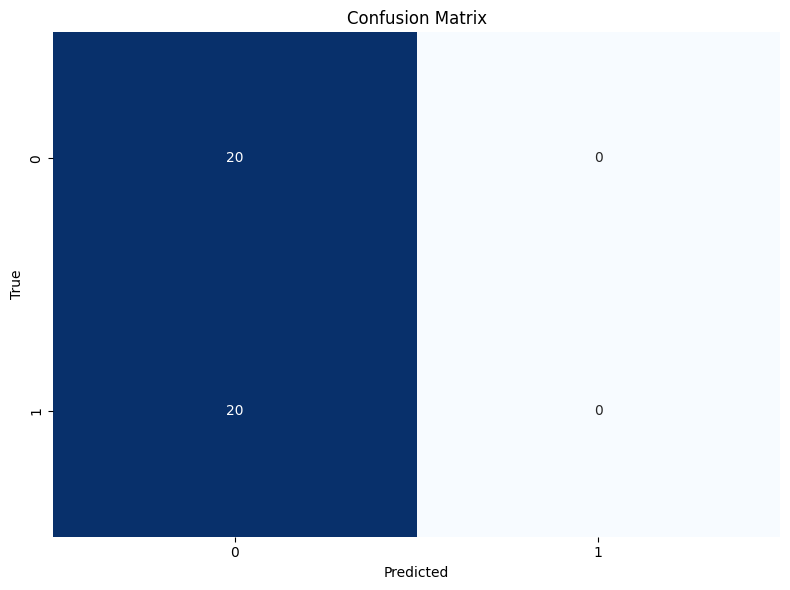

In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, glcm_features, labels in test_loader:
        images, glcm_features, labels = images.to(device), glcm_features.to(device), labels.to(device)
        outputs = model(images, glcm_features)
        _, predicted = torch.max(outputs.data, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Hitung precision, recall, f1 untuk setiap kelas
precision = precision_score(all_labels, all_preds, average=None, zero_division=0)
recall = recall_score(all_labels, all_preds, average=None, zero_division=0)
f1 = f1_score(all_labels, all_preds, average=None, zero_division=0)

# Tampilkan nilai precision, recall, dan f1-score per kelas
num_classes = len(set(all_labels))  # Jumlah kelas yang ada di dataset
for i in range(num_classes):
    print(f"Class {i}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall:    {recall[i]:.4f}")
    print(f"  F1-Score:  {f1[i]:.4f}")
    print("-" * 30)

# Tampilkan classification report
print('\nClassification Report:')
print(classification_report(all_labels, all_preds, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


## Save The Model

In [21]:
torch.save(model.state_dict(), 'hybrid_glcm_cnn_model.pth')